In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error,plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import os
import math

In [30]:
path = "../data"
sentiment_frame = pd.read_csv(os.path.join(path,"sentiment_analysis.csv"))

In [31]:
sentiment_frame.shape

(10278, 10)

In [3]:
df = pd.read_csv(os.path.join(path,"spotifyqueriesresults.csv"),index_col = None).drop("Unnamed: 0",axis =1)
df = df.join(sentiment_frame[["preprocess_lyrics","tb_Pol","tb_Subj","compound","neg","neu","pos"]])
#prune bad lists
df = df[df['playlist_id'] != "44ihc7hk5ewgfWsy5x9QKL"] 
df = df[df['playlist_id'] != "5LjyNDmQhoODlJZaNV7fxj"]
df = df[df["playlist_id"] != "6s9wratabPxp4NwDZAbnwl"]
df = df[df["playlist_id"] != "69CBhCYkS3jzhmzRoghVWG"]
df = df[df["playlist_id"] != "4MRjoBGxVSA8JcBiJr6C3Y"]
df = df[df["playlist_id"] != "171HLt90V1fhorEJWF45VO"]
df = df[df["playlist_id"] != "4XHLVq8ke4mxKeZvqgJjNZ"]
df = df[df["playlist_id"] != "2fFSLnFhz5nem6mWRWEJaD"]

In [4]:
df.groupby("category").mean()

,acousticness,danceability,energy,instrumentalness,key,loudness,mode,speechiness,tempo,valence,tb_Pol,tb_Subj,compound,neg,neu,pos
category,,,,,,,,,,,,,,,,
joyful activation,0.168452,0.673130,0.711562,0.090740,5.498336,-6.984493,0.537438,0.112456,119.615384,0.536217,0.053640,0.480630,0.244080,0.134211,0.681598,0.184193
nostalgia,0.479898,0.555012,0.449560,0.217544,5.205546,-10.844982,0.693312,0.064300,115.925433,0.372304,0.079855,0.486460,0.384617,0.124854,0.665743,0.209428
peacefullness,0.679829,0.484904,0.284925,0.493209,5.140549,-16.803195,0.665590,0.065582,109.501991,0.279912,0.077604,0.484322,0.496039,0.120899,0.663764,0.215365
power,0.217689,0.623068,0.668679,0.104055,5.213365,-7.638308,0.630715,0.102970,121.651104,0.493260,0.066237,0.504239,0.292202,0.139268,0.657706,0.203008
sadness,0.404430,0.589158,0.507265,0.029341,5.296602,-8.320311,0.684114,0.086441,118.146968,0.348660,0.044376,0.528942,0.233212,0.167719,0.604403,0.227932
tenderness,0.408639,0.593442,0.480337,0.109199,5.104010,-8.967726,0.547619,0.087788,113.502149,0.368376,0.079764,0.497226,0.495318,0.125729,0.640691,0.233569
tension,0.183656,0.599337,0.708396,0.056457,5.171239,-6.524758,0.663198,0.108359,123.853668,0.484920,0.009153,0.523637,-0.042296,0.184954,0.633044,0.182017
transcendence,0.403627,0.506168,0.498595,0.233230,5.141631,-11.564384,0.644635,0.059453,115.233833,0.448944,0.087836,0.469204,0.411503,0.113696,0.680891,0.205387
wonder,0.220666,0.651592,0.660450,0.060559,5.260664,-6.736567,0.676935,0.083493,119.018748,0.554548,0.089127,0.494184,0.440387,0.128009,0.643928,0.226921


In [5]:
df.shape

(9894, 22)

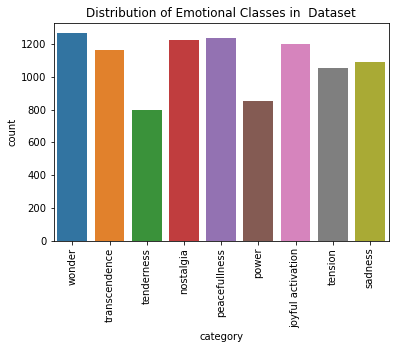

In [41]:
ax = sns.countplot(x = df.category)
title = ax.set_title("Distribution of Emotional Classes in  Dataset")
xticks = plt.xticks(rotation = 90)
plt.savefig('distribution3.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


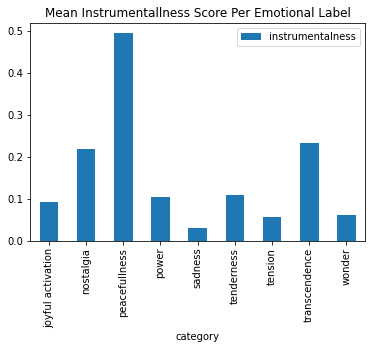

In [71]:
ax = df.groupby("category").mean()["instrumentalness"].to_frame().plot(kind = "bar")
title = ax.set_title("Mean Instrumentallness Score Per Emotional Label")
plt.savefig('instrumentallness.eps',bbox_inches='tight')

## Baseline randomforest

In [162]:
model_frame = df.drop(["artist","class","playlist_id","title"],axis = 1)

In [163]:
X = model_frame.drop("category",axis =1)
y = model_frame["category"]

In [164]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [64]:
clf = RandomForestClassifier()

In [166]:
clf.fit(X_train,y_train)

RandomForestClassifier()

In [167]:
y_pred = clf.predict(X_test)

In [168]:
print(classification_report(y_test,y_pred))

                   precision    recall  f1-score   support

joyful activation       0.41      0.43      0.42       255
        nostalgia       0.29      0.27      0.28       256
    peacefullness       0.56      0.52      0.54       260
            power       0.19      0.12      0.14       173
          sadness       0.28      0.36      0.31       196
       tenderness       0.23      0.20      0.21       147
          tension       0.31      0.28      0.29       202
    transcendence       0.42      0.50      0.46       231
           wonder       0.34      0.38      0.36       259

         accuracy                           0.36      1979
        macro avg       0.34      0.34      0.34      1979
     weighted avg       0.35      0.36      0.35      1979



## Baseline XGBoost

In [169]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

In [170]:
print(classification_report(y_test,y_pred))

                   precision    recall  f1-score   support

joyful activation       0.40      0.48      0.44       255
        nostalgia       0.29      0.25      0.27       256
    peacefullness       0.64      0.50      0.56       260
            power       0.23      0.08      0.12       173
          sadness       0.24      0.42      0.30       196
       tenderness       0.30      0.15      0.20       147
          tension       0.30      0.21      0.25       202
    transcendence       0.42      0.52      0.46       231
           wonder       0.32      0.40      0.35       259

         accuracy                           0.35      1979
        macro avg       0.35      0.34      0.33      1979
     weighted avg       0.36      0.35      0.34      1979



## TF-IDF
$w$ = $tf$ $\times$ $log{\frac{N}{docfreq}}$

"TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus"

in our case,words are musicians and collections are playlist categories

N = total playlists with label $j$

tf = number of times artists $i$ is in playlist category $j$

docfreq = number of playlists that have artist $i$

In [222]:
categories = ["wonder","transcendence","nostalgia","tenderness","peacefullness","power","joyful activation","tension","sadness"]

In [261]:
def tf_idf(artist,label):
    tf = len(df[df.category == label ][df.artist == artist])
    N = len(df[df.category == label ])
    docfreq = len(df[df.artist == artist ])
    
    return tf * math.log(N/docfreq)

In [262]:
def get_tf_idf_wonder(row):
    return tf_idf(row["artist"],"wonder")
def get_tf_idf_transcendence(row):
    return tf_idf(row["artist"],"transcendence")
def get_tf_idf_nostalgia(row):
    return tf_idf(row["artist"],"nostalgia")
def get_tf_idf_tenderness(row):
    return tf_idf(row["artist"],"tenderness")
def get_tf_idf_peacefullness(row):
    return tf_idf(row["artist"],"peacefullness")
def get_tf_idf_power(row):
    return tf_idf(row["artist"],"power")
def get_tf_idf_joy(row):
    return tf_idf(row["artist"],"joyful activation")
def get_tf_idf_tension(row):
    return tf_idf(row["artist"],"tension")
def get_tf_idf_sadness(row):
    return tf_idf(row["artist"],"sadness")

In [263]:
df["tf_idf_wonder"] = df.apply(get_tf_idf_wonder, axis = 1)
df["tf_idf_transcendence"] = df.apply(get_tf_idf_transcendence, axis = 1)
df["tf_idf_nostalgia"] = df.apply(get_tf_idf_nostalgia, axis = 1)
df["tf_idf_tenderness"] = df.apply(get_tf_idf_tenderness, axis = 1)
df["tf_idf_peacefullness"] = df.apply(get_tf_idf_peacefullness, axis = 1)
df["tf_idf_power"] = df.apply(get_tf_idf_power, axis = 1)
df["tf_idf_joyful"] = df.apply(get_tf_idf_joy, axis = 1)
df["tf_idf_tension"] = df.apply(get_tf_idf_tension, axis = 1)
df["tf_idf_sadness"] = df.apply(get_tf_idf_sadness, axis = 1)

In [ ]:
df.to_csv(os.path.join(path,"spotifyquerieswithtfidflabels.csv"))

## Modelling again

In [294]:
# model_frame = df.drop(["artist","class","playlist_id","title"],axis = 1)
model_frame = df.drop(["artist","class","playlist_id","title"],axis = 1).sample(len(model_frame))

In [296]:
X = model_frame.drop("category",axis =1)
y = model_frame["category"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [297]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [298]:
print(classification_report(y_test,y_pred))

                   precision    recall  f1-score   support

joyful activation       0.72      0.78      0.75       227
        nostalgia       0.76      0.76      0.76       246
    peacefullness       0.82      0.77      0.79       265
            power       0.63      0.56      0.59       160
          sadness       0.67      0.69      0.68       222
       tenderness       0.69      0.67      0.68       183
          tension       0.66      0.72      0.69       191
    transcendence       0.83      0.83      0.83       214
           wonder       0.71      0.69      0.70       271

         accuracy                           0.73      1979
        macro avg       0.72      0.72      0.72      1979
     weighted avg       0.73      0.73      0.73      1979



[Text(0, 0, ''),
 Text(0, 0, 'joyful activation'),
 Text(0, 0, 'nostalgia'),
 Text(0, 0, 'peacefullness'),
 Text(0, 0, 'power'),
 Text(0, 0, 'sadness'),
 Text(0, 0, 'tenderness'),
 Text(0, 0, 'tension'),
 Text(0, 0, 'transcendence'),
 Text(0, 0, 'wonder')]

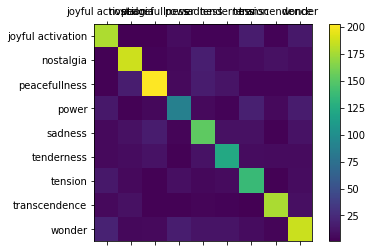

In [318]:
labels = ['joyful activation', 'nostalgia','peacefullness','power','sadness'
         ,'tenderness','tension','transcendence','wonder']
cm = confusion_matrix(y_test,y_pred,labels)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

In [72]:
queries_tf_idf[["artist","title","prediction","category"]].sample(25)

NameError: name 'queries_tf_idf' is not defined

In [278]:
feature_list = X.columns
importances = list(clf.feature_importances_)
feature_importance = [(feature, round(importance,2)) for feature,importance in zip(feature_list,importances)] 

### Join sentiment with tf idf

In [74]:
idf_sentiment_frame = pd.read_csv(os.path.join(path,"spotifyquerieswithtfidflabels.csv"))
df = df.set_index(idf_sentiment_frame.index)

In [129]:
idf_sentiment_frame[idf_sentiment_frame["artist"] == "Rihanna"].iloc[0]

Unnamed: 0                                 241
acousticness                           0.00108
artist                                 Rihanna
class                                    happy
danceability                             0.554
energy                                   0.669
instrumentalness                             0
key                                         11
loudness                                -6.041
mode                                         0
playlist_id             37i9dQZF1DWYtQSOiZF6hj
speechiness                             0.0426
tempo                                   91.993
title                                 Diamonds
valence                                  0.405
category                                wonder
tf_idf_wonder                          10.8518
tf_idf_transcendence                         0
tf_idf_nostalgia                       14.3406
tf_idf_tenderness                      31.5575
tf_idf_peacefullness                   21.5694
tf_idf_power 

In [126]:
idf_sentiment_frame[idf_sentiment_frame["artist"] == "Juice WRLD"].iloc[0]

Unnamed: 0                                                699
acousticness                                           0.0768
artist                                             Juice WRLD
class                                                   smile
danceability                                            0.581
energy                                                  0.673
instrumentalness                                            0
key                                                         0
loudness                                               -4.421
mode                                                        0
playlist_id                            21Uh0HthrGV8qjwXFNfvuS
speechiness                                            0.0549
tempo                                                 160.073
title                   Ring Ring (with Rvssian feat. Clever)
valence                                                 0.621
category                                               wonder
tf_idf_w

In [54]:
idf_sentiment_frame = idf_sentiment_frame.join(df[["preprocess_lyrics","tb_Pol","tb_Subj","compound","neg","neu","pos"]])

modelling again

In [55]:
idf_sentiment_frame.dtypes

Unnamed: 0                int64
acousticness            float64
artist                   object
class                    object
danceability            float64
energy                  float64
instrumentalness        float64
key                       int64
loudness                float64
mode                      int64
playlist_id              object
speechiness             float64
tempo                   float64
title                    object
valence                 float64
category                 object
tf_idf_wonder           float64
tf_idf_transcendence    float64
tf_idf_nostalgia        float64
tf_idf_tenderness       float64
tf_idf_peacefullness    float64
tf_idf_power            float64
tf_idf_joyful           float64
tf_idf_tension          float64
tf_idf_sadness          float64
preprocess_lyrics        object
tb_Pol                  float64
tb_Subj                 float64
compound                float64
neg                     float64
neu                     float64
pos     

In [57]:
model_frame_2 = idf_sentiment_frame.drop(["artist","class","playlist_id","title","preprocess_lyrics","Unnamed: 0"],axis = 1).sample(len(idf_sentiment_frame))

In [61]:
#impute missing values
model_frame_2 = model_frame_2.fillna(model_frame_2.mean())

In [62]:
X = model_frame_2.drop("category",axis =1)
y = model_frame_2["category"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

In [65]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [66]:
print(classification_report(y_test,y_pred))

                   precision    recall  f1-score   support

joyful activation       0.73      0.81      0.77       226
        nostalgia       0.76      0.73      0.75       237
    peacefullness       0.76      0.80      0.78       236
            power       0.65      0.56      0.60       180
          sadness       0.68      0.66      0.67       228
       tenderness       0.59      0.64      0.61       144
          tension       0.76      0.68      0.72       225
    transcendence       0.84      0.82      0.83       257
           wonder       0.67      0.72      0.69       246

         accuracy                           0.72      1979
        macro avg       0.72      0.71      0.71      1979
     weighted avg       0.72      0.72      0.72      1979



In [67]:
feature_list = X.columns
importances = list(clf.feature_importances_)
feature_importance = [(feature, round(importance,2)) for feature,importance in zip(feature_list,importances)] 

In [68]:
feature_importance

[('acousticness', 0.03),
 ('danceability', 0.03),
 ('energy', 0.03),
 ('instrumentalness', 0.02),
 ('key', 0.01),
 ('loudness', 0.03),
 ('mode', 0.0),
 ('speechiness', 0.03),
 ('tempo', 0.02),
 ('valence', 0.03),
 ('tf_idf_wonder', 0.08),
 ('tf_idf_transcendence', 0.09),
 ('tf_idf_nostalgia', 0.09),
 ('tf_idf_tenderness', 0.06),
 ('tf_idf_peacefullness', 0.08),
 ('tf_idf_power', 0.06),
 ('tf_idf_joyful', 0.09),
 ('tf_idf_tension', 0.07),
 ('tf_idf_sadness', 0.07),
 ('tb_Pol', 0.01),
 ('tb_Subj', 0.01),
 ('compound', 0.02),
 ('neg', 0.01),
 ('neu', 0.01),
 ('pos', 0.01)]